In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score
from sklearn.preprocessing import label_binarize
import pickle
from MVDD.MVDD import MVDD
import MVDD.MVDD_Generator as mvGen

%matplotlib inline

plt.rc('font', size=12)
warnings.filterwarnings('ignore')

In [2]:
#HELPER CODE

#Validation Method
def performValidation(model, data, realScores, aucName):
    #DT Accuracy
    print("*****DECISION TREE*****")
    y_pred = model.predictDTScoreSet(data)
    
    acc = accuracy_score(realScores,y_pred)
    recall = recall_score(realScores,y_pred,average='weighted')
    f1 = f1_score(realScores,y_pred,average='weighted')
    prec = precision_score(realScores,y_pred,average='weighted')
    
    #ROC AUC Score
    y_score = label_binarize(y_pred, classes=[1,2,3,4,5])
    y_test = label_binarize(realScores, classes=[1,2,3,4,5])
    fpr, tpr, roc_auc = mvGen.getClassROC(y_test,y_score)
    
    mvGen.getAverageROCGraph(fpr, tpr, roc_auc, aucName)

    print("DT Accuracy:", acc)
    print("DT Recall:", recall)
    print("DT F1 Score:", f1)
    print("DT Precision:", prec)
    
    #MVDD Accuracy
    print("\n*****MVDD*****")
    y_pred = model.predictScoreSet(data)
    
    acc = accuracy_score(realScores,y_pred)
    recall = recall_score(realScores,y_pred,average='weighted')
    f1 = f1_score(realScores,y_pred,average='weighted')
    prec = precision_score(realScores,y_pred,average='weighted')
    
    #ROC AUC Score
    y_score = label_binarize(y_pred, classes=[1,2,3,4,5])
    y_test = label_binarize(realScores, classes=[1,2,3,4,5])
    fpr, tpr, roc_auc = mvGen.getClassROC(y_test,y_score)
    
    mvGen.getAverageROCGraph(fpr, tpr, roc_auc, aucName)

    print("Accuracy:", acc)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Precision:", prec)
    
    return acc, recall, f1, prec

# Hemodynamic Model Validation

## Label = Death
Note: validation sets only have death labels to validate for hemo

### Cardiogenic Shock

In [3]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/Hemo_Death')

*****DECISION TREE*****


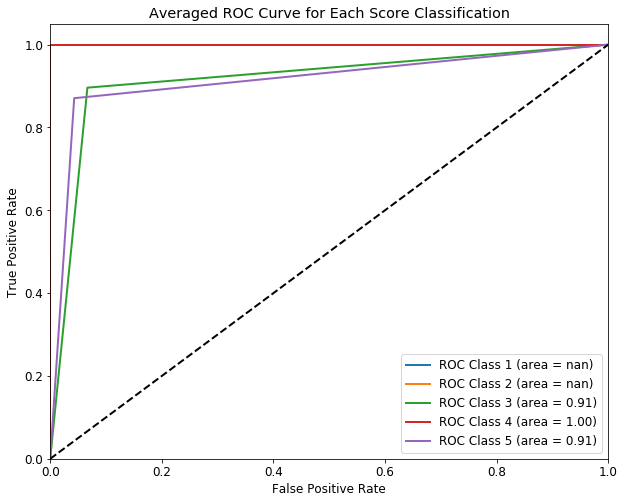

DT Accuracy: 0.9238410596026491
DT Recall: 0.9238410596026491
DT F1 Score: 0.9243119941133187
DT Precision: 0.9262789355367883

*****MVDD*****


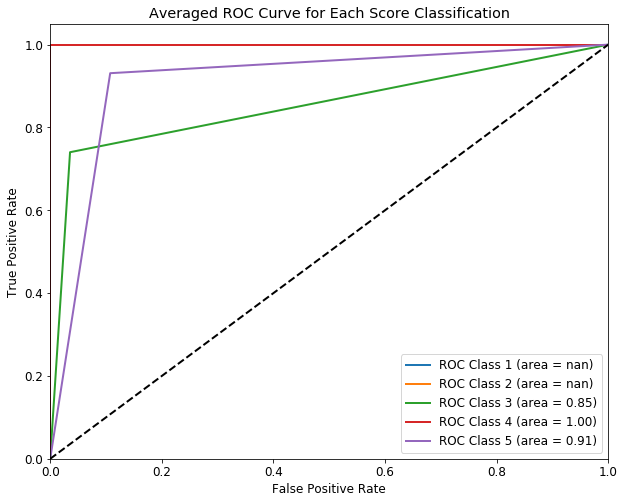

Accuracy: 0.9072847682119205
Recall: 0.9072847682119205
F1 Score: 0.9056471059556778
Precision: 0.9086029037187978


In [4]:
hemoCohort = pd.read_csv("Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_Hemo.csv", sep=",", index_col='ID')
deathLabels = hemoCohort['ScoreDeath']

hemo = hemoCohort.drop('ScoreDeath', axis=1)
hemo = hemo.drop('Score', axis=1)
hemo = hemo.drop('ScoreRehosp', axis=1)
hemo = hemo.drop('ScoreReadmission', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=hemo, realScores=deathLabels, aucName='HemoCardShock')

### Serial Cardiac

In [5]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/Hemo_Death')

*****DECISION TREE*****


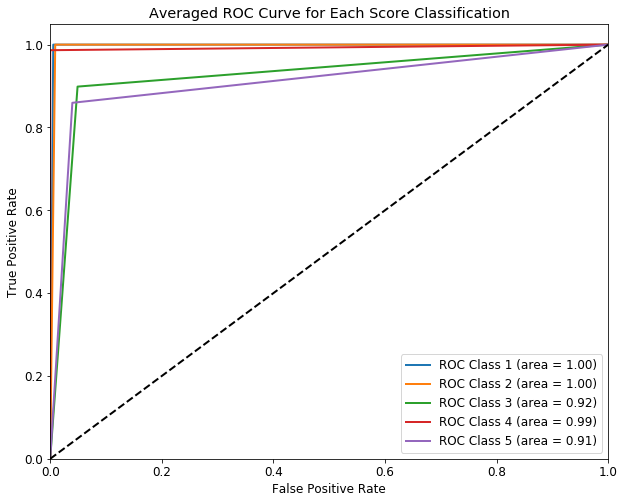

DT Accuracy: 0.9226618705035972
DT Recall: 0.9226618705035972
DT F1 Score: 0.9258780922023524
DT Precision: 0.931524108444337

*****MVDD*****


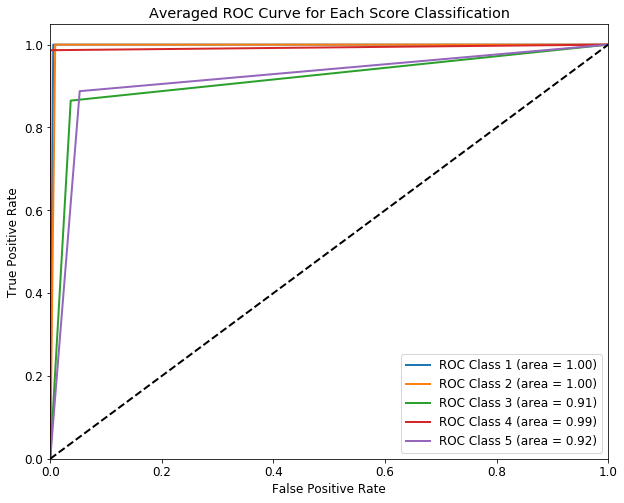

Accuracy: 0.9226618705035972
Recall: 0.9226618705035972
F1 Score: 0.925854080911775
Precision: 0.9310111351478257


In [6]:
hemoCohort = pd.read_csv("Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_Hemo.csv", sep=",", index_col='ID')
deathLabels = hemoCohort['ScoreDeath']

hemo = hemoCohort.drop('ScoreDeath', axis=1)
hemo = hemo.drop('Score', axis=1)
hemo = hemo.drop('ScoreRehosp', axis=1)
hemo = hemo.drop('ScoreReadmission', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=hemo, realScores=deathLabels, aucName='HemoSerialCardiac')

# All Data Model Validation

## Label = All Outcomes
Note: only HF-Action has all outcome label

### HF-ACTION All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_AllOutcomes')

In [ ]:
guideAllData = pd.read_csv("Data Validation/HF-ACTION/Preprocessed Data/HF-ACTION_AllData.csv", sep=",", index_col='ID')
labels = guideAllData['Score']

allD = allD.drop('Score', axis=1)
allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=allD, realScores=labels, aucName='AllDataHFaction')

## Label = Death
Note: All Validation Datasets have the death label

### Cardiogenic Shock All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Death')

In [ ]:
allDataCohort = pd.read_csv("Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_AllData.csv", sep=",", index_col='ID')
deathLabels = allDataCohort['ScoreDeath']

ad = allDataCohort.drop('ScoreDeath', axis=1)
ad = ad.drop('Score', axis=1)
ad = ad.drop('ScoreRehosp', axis=1)
ad = ad.drop('ScoreReadmission', axis=1)
ad = ad.replace(np.inf, 0)
ad = ad.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=ad, realScores=deathLabels, aucName='AllDataCardShock')

### Serial Cardiac All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Death')

In [ ]:
allDataCohort = pd.read_csv("Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_AllData.csv", sep=",", index_col='ID')
deathLabels = allDataCohort['ScoreDeath']

ad = allDataCohort.drop('ScoreDeath', axis=1)
ad = ad.drop('Score', axis=1)
ad = ad.drop('ScoreRehosp', axis=1)
ad = ad.drop('ScoreReadmission', axis=1)
ad = ad.replace(np.inf, 0)
ad = ad.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=ad, realScores=deathLabels, aucName='AllDataSerialCardiac')

### HF-ACTION All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Death')

In [ ]:
guideAllData = pd.read_csv("Data Validation/HF-ACTION/Preprocessed Data/HF-ACTION_AllData.csv", sep=",", index_col='ID')
deathLabels = guideAllData['ScoreDeath']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=allD, realScores=deathLabels, aucName='AllDataHFaction')

### BEST All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Death')

In [ ]:
guideAllData = pd.read_csv("Data Validation/BEST/Preprocessed Data/BEST_AllData.csv", sep=",", index_col='ID')
deathLabels = guideAllData['ScoreDeath']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=allD, realScores=deathLabels, aucName='AllDataBest')

### GUIDE-IT All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Death')

In [ ]:
guideAllData = pd.read_csv("Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AllData.csv", sep=",", index_col='ID')
deathLabels = guideAllData['ScoreDeath']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=allD, realScores=deathLabels, aucName='AllDataGuideIt')

## Label = Rehospitalization
Note: Only HF-ACTION, BEST and GUIDE-IT have rehosp

### HF-ACTION All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Rehosp')

In [ ]:
guideAllData = pd.read_csv("Data Validation/HF-ACTION/Preprocessed Data/HF-ACTION_AllData.csv", sep=",", index_col='ID')
labels = guideAllData['ScoreRehosp']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=allD, realScores=labels, aucName='AllDataHFaction')

### BEST All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Rehosp')

In [ ]:
guideAllData = pd.read_csv("Data Validation/BEST/Preprocessed Data/BEST_AllData.csv", sep=",", index_col='ID')
labels = guideAllData['ScoreRehosp']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=allD, realScores=labels, aucName='AllDataBest')

### GUIDE-IT All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Rehosp')

In [ ]:
guideAllData = pd.read_csv("Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AllData.csv", sep=",", index_col='ID')
labels = guideAllData['ScoreRehosp']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=allD, realScores=labels, aucName='AllDataGuideIt')

## Label = Readmission
Note: only HF-ACTION has readm

### HF-ACTION All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Readmission')

In [ ]:
guideAllData = pd.read_csv("Data Validation/HF-ACTION/Preprocessed Data/HF-ACTION_AllData.csv", sep=",", index_col='ID')
labels = guideAllData['ScoreReadmission']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=allD, realScores=labels, aucName='AllDataHFaction')